## CLUSTERING CL

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score,silhouette_samples, pairwise_distances
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from math import pi
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_cl = pd.read_csv("CL_DATA.csv")
df_cl.head()

,Date,Open,High,Low,Close,Volume,Close_eurusd,Close_sp500,Close_xle,Noticia_EIA,...,importacion_pct_change,exportacion_pct_change,inventario_pct_change,produccion_cambio_acumulativo,importacion_cambio_acumulativo,exportacion_cambio_acumulativo,inventario_cambio_acumulativo,Change_diff,racha_change,racha_change_id
0,2014-01-02,98.50,98.97,95.34,95.44,251248,1.3652,1826.50,87.250000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2014-01-03,95.47,95.74,93.86,93.96,215522,1.3598,1825.50,86.930000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.53,1.0,2
2,2014-01-06,94.18,94.59,93.20,93.43,189379,1.3635,1820.75,87.050003,Change in energy prices mixed in 2013 as price...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.78,1.0,2
3,2014-01-07,93.60,94.22,93.35,93.67,177182,1.3617,1830.75,87.709999,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.87,1.0,2
4,2014-01-08,93.96,94.18,92.26,92.33,244855,1.3582,1832.50,87.099998,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.80,-1.0,3


In [3]:
#Nos quedamos solo con variables numericas
df = df_cl.select_dtypes(include=[np.number])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2663 entries, 0 to 2662
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Open                            2663 non-null   float64
 1   High                            2663 non-null   float64
 2   Low                             2663 non-null   float64
 3   Close                           2663 non-null   float64
 4   Volume                          2663 non-null   int64  
 5   Close_eurusd                    2662 non-null   float64
 6   Close_sp500                     2662 non-null   float64
 7   Close_xle                       2662 non-null   float64
 8   produccion_diaria_promedio      2662 non-null   float64
 9   importacion_diaria_promedio     2662 non-null   float64
 10  exportacion_diaria_promedio     2662 non-null   float64
 11  inventario_final_semanal        553 non-null    float64
 12  year                            26

### Data preparation & Feature engineering

In [4]:
# Calcular métricas derivadas
df["rango_relativo_diario"] = (df["High"] - df["Low"]) / df["Close"]
df["diferencia_apertura_cierre"] = (df["Close"] - df["Open"]) / df["Open"]

# Eliminar variables originales
df = df.drop(columns=["Open", "High", "Low","racha_change_id"], axis=1)

In [5]:
# Cortar el DataFrame, manteniendo todas las filas excepto las primeras 5 y las últimas 5
df = df.iloc[5:-5]

In [6]:
# Rellenar los valores nulos en la columna "inventario_final_semanal" con el valor anterior en la misma columna
df["inventario_final_semanal"] = df["inventario_final_semanal"].ffill().bfill()


In [7]:
### Fila 1106 tiene valores nulos, los rellenamos con el valor anterior
df.loc[1106] = df.loc[1106].ffill()

In [8]:
# Rellenar los valores nulos en las columnas "year_max_anterior" y "year_min_anterior" con el valor anterior en la misma columna.
df[["year_max_anterior","year_min_anterior"]] = df[["year_max_anterior","year_min_anterior"]].bfill()

In [9]:
# Rellenar los valores nulos en las columnas "monthly_min_anterior" y "monthly_max_anterior" con el valor anterior en la misma columna
df[["monthly_min_anterior","monthly_max_anterior"]] = df[["monthly_min_anterior","monthly_max_anterior"]].bfill()

In [10]:
# Rellenar los valores nulos en las columnas "corr_oil_xle", "corr_oil_eurusd" y "corr_oil_sp500" con el valor anterior en la misma columna
df[["corr_oil_xle","corr_oil_eurusd","corr_oil_sp500"]] = df[["corr_oil_xle","corr_oil_eurusd","corr_oil_sp500"]].bfill()

In [11]:
# Rellenar los valores nulos en la columna "volume_change" con el valor de la fila siguiente en la misma columna ya que era un valor infinito
df.loc[2332,"volume_change"] = df.loc[2333,"volume_change"]


In [12]:
#Remplazamos los valores atipicos con los valores del día anterior
df.loc[1106,["Close_eurusd","Close_sp500", "Close_xle"]] = df.loc[1105,["Close_eurusd","Close_sp500", "Close_xle"]]

df[["Close_eurusd","Close_sp500", "Close_xle"]].sort_values(by=["Close_eurusd","Close_sp500", "Close_xle"],ascending=False).head()

,Close_eurusd,Close_sp500,Close_xle
50,1.3941,1857.75,86.839996
85,1.3932,1864.25,94.300003
51,1.3928,1870.75,87.570000
86,1.3915,1874.25,95.120003
49,1.3904,1840.00,86.379997


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 5 to 2657
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Close                           2653 non-null   float64
 1   Volume                          2653 non-null   int64  
 2   Close_eurusd                    2653 non-null   float64
 3   Close_sp500                     2653 non-null   float64
 4   Close_xle                       2653 non-null   float64
 5   produccion_diaria_promedio      2653 non-null   float64
 6   importacion_diaria_promedio     2653 non-null   float64
 7   exportacion_diaria_promedio     2653 non-null   float64
 8   inventario_final_semanal        2653 non-null   float64
 9   year                            2653 non-null   int64  
 10  month                           2653 non-null   int64  
 11  week                            2653 non-null   int64  
 12  day_max_anterior                26

## K-means

#### Normalizamos los datos

In [14]:
# Normalizamos los datos para que el algoritmo funcione correctamente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

#### Método del codo para determinar el número óptimo de clusters

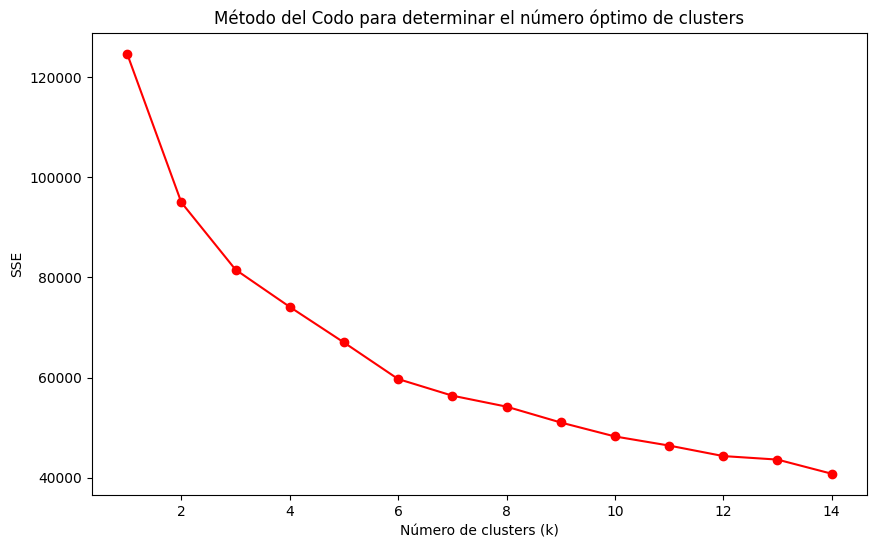

K = 1, Inercia = 124690.99999999999
K = 2, Inercia = 94995.42216888527
K = 3, Inercia = 81568.77996409044
K = 4, Inercia = 74129.41869190446
K = 5, Inercia = 67021.69812412975
K = 6, Inercia = 59719.0691433615
K = 7, Inercia = 56398.07207281238
K = 8, Inercia = 54205.78675820304
K = 9, Inercia = 51039.63454349649
K = 10, Inercia = 48251.46433642848
K = 11, Inercia = 46430.95007838365
K = 12, Inercia = 44332.38258706112
K = 13, Inercia = 43630.22917126421
K = 14, Inercia = 40807.560878291806


In [15]:
k_ran = range(1, 15)
sse = []  # Lista para almacenar la inercia (SSE) de cada k

# Cálculo de la inercia para diferentes valores de k
for k in k_ran:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)  # Ajustamos el modelo para cada valor de k
    kmeans.fit(X_scaled)  # Ajustar el modelo con los datos escalados
    sse.append(kmeans.inertia_)  # Añadir la inercia a la lista

# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_ran, sse, marker='o', color='red')
plt.xlabel('Número de clusters (k)')
plt.ylabel('SSE')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

# Imprimir la inercia para cada valor de K
for k, inercia in zip(k_ran, sse):
    print(f'K = {k}, Inercia = {inercia}')

###  Silhouette Score

K = 2, Silhouette Score = 0.259
K = 3, Silhouette Score = 0.293
K = 4, Silhouette Score = 0.218
K = 5, Silhouette Score = 0.242
K = 6, Silhouette Score = 0.241
K = 7, Silhouette Score = 0.240
K = 8, Silhouette Score = 0.236
K = 9, Silhouette Score = 0.253
K = 10, Silhouette Score = 0.243

Número óptimo de clusters según Silhouette Score: 3


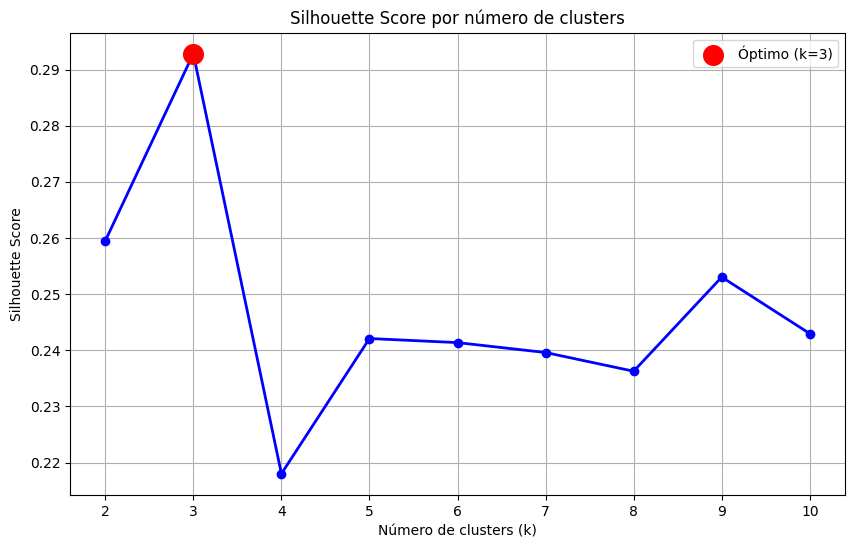

In [16]:
# Calcular Silhouette Score para diferentes valores de K
silhouette_scores = []
k_range = range(2, 11)  # Rango de 2 a 10 clusters

# Calcular score para cada k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {k}, Silhouette Score = {silhouette_avg:.3f}")

# Encontrar el k óptimo
k_optimo = k_range[np.argmax(silhouette_scores)]

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), silhouette_scores, marker='o', color='blue', linewidth=2)
plt.scatter(k_optimo, max(silhouette_scores), color='red', s=200, 
           label=f'Óptimo (k={k_optimo})', zorder=5)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por número de clusters')
plt.grid(True)
plt.legend()

# Mostrar el k óptimo
print(f"\nNúmero óptimo de clusters según Silhouette Score: {k_optimo}")
plt.show()


#### Aplicamos el algoritmo K-Means con n_clusters=3""

In [17]:
# Aplicar el algoritmo K-Means con n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Calcula la inercia del modelo 
inertia = kmeans.inertia_  # Inercia total

In [18]:
# variables medias y desviaciones estandar para la normalización
medias = scaler.mean_
desviaciones = scaler.scale_

#Desnormalizar los centroides
centroides_desnormalizados = kmeans.cluster_centers_ * desviaciones + medias

# Crear un DataFrame con los centroides desnormalizados
centroides = pd.DataFrame(centroides_desnormalizados, columns=df.columns)

# Agregar los clusters al DataFrame original
df['cluster'] = clusters

### Perfilado y analisis de los centroides

In [ ]:
centroides_analisis = centroides.copy()
centroides_analisis


Rangos de Variables:
--------------------------------------------------------------------------------
                   Variable       Min          Max
             anual_pct_diff   26.5445     109.2514
                     Change  -24.3900      20.4600
                 volatility    0.0600      17.2400
                     Volume    0.0000 2288230.0000
 diferencia_apertura_cierre   -3.1224       0.2046
 produccion_diaria_promedio 8044.0000   13300.0000
importacion_diaria_promedio 4599.0000    9372.0000
exportacion_diaria_promedio   58.0000    5629.0000
--------------------------------------------------------------------------------


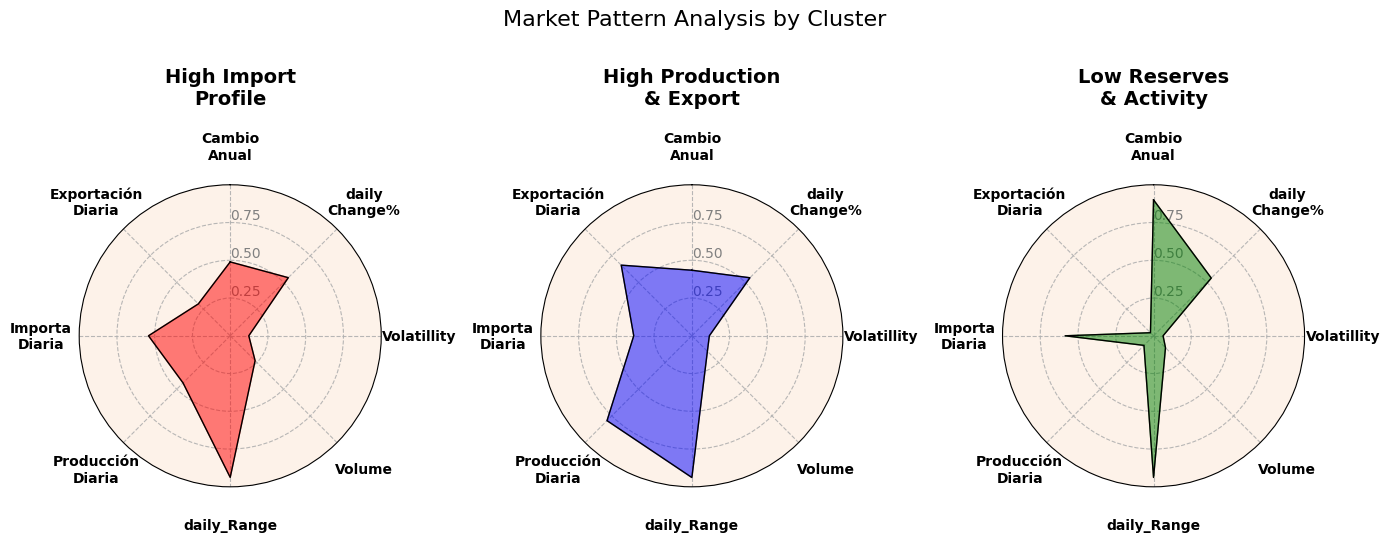

,anual_pct_diff,Change,volatility,Volume,diferencia_apertura_cierre,produccion_diaria_promedio,importacion_diaria_promedio,exportacion_diaria_promedio
0,67.0099,0.0179,2.1746,533504.1445,-0.0028,10364.7380,7181.4815,1721.3696
1,62.4505,-0.0137,2.0483,332608.1439,-0.0001,12220.7071,6436.5101,3743.0997
2,100.9888,-0.1414,1.1440,256122.3149,-0.0014,8516.3617,7394.9872,218.5532


In [21]:
centroides_analisis[["anual_pct_diff", "Change_diff", "volatility", "weekly_pct_diff", "monthly_pct_diff",
         "produccion_diaria_promedio", "importacion_diaria_promedio", "exportacion_diaria_promedio"]]
# Función para analizar rangos de variables
def print_variable_ranges(df, centroides, columns_to_analyze):
   ranges_df = pd.DataFrame({
       'Variable': columns_to_analyze,
       'Min': [df[col].min() for col in columns_to_analyze],
       'Max': [df[col].max() for col in columns_to_analyze]
   })
   pd.set_option('display.float_format', lambda x: '%.4f' % x)
   print("\nRangos de Variables:")
   print("-" * 80)
   print(ranges_df.to_string(index=False))
   print("-" * 80)

# Define column labels dictionary
column_labels = {
   "anual_pct_diff": "Cambio\nAnual",
   "Change": "daily\nChange%", 
   "volatility": "Volatillity",
   "Volume": "Volume",
   "diferencia_apertura_cierre": "daily_Range",
   "produccion_diaria_promedio": "Producción\nDiaria",
   "importacion_diaria_promedio": "Importa\nDiaria",
   "exportacion_diaria_promedio": "Exportación\nDiaria"
}

titles = {
   0: 'High Import\nProfile',
   1: 'High Production\n& Export',
   2: 'Low Reserves\n& Activity'
}

# Define columns to use
columns = ["anual_pct_diff", "Change", "volatility", "Volume", "diferencia_apertura_cierre",
         "produccion_diaria_promedio", "importacion_diaria_promedio", "exportacion_diaria_promedio"]
print_variable_ranges(df, centroides_analisis, columns)

# Normalización de los centroides
resultado_normalizado = centroides_analisis[columns].copy()

for col in columns:
   min_val = df[col].min()
   max_val = df[col].max()
   resultado_normalizado[col] = (resultado_normalizado[col] - min_val) / (max_val - min_val)

# Configuración visualización mejorada
plt.figure(figsize=(14,5))
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Market Pattern Analysis by Cluster', fontsize=16, y=1.05)

bg_colors = ['#FDF2E9','#FDF2E9','#FDF2E9']
colors = ['Red', 'blue', 'green']

for row in range(3):
   ax = plt.subplot(1, 3, row + 1, polar=True)
   ax.set_facecolor(bg_colors[row])
   
   categories = [column_labels[col] for col in columns]
   N = len(categories)
   angles = [n / float(N) * 2 * pi for n in range(N)]
   angles += angles[:1]
   
   ax.set_theta_offset(pi / 2)
   ax.set_theta_direction(-1)
   ax.grid(True, linestyle='--', alpha=0.9)
   ax.set_axisbelow(True)
   
   # Ajuste de posición de etiquetas
   ax.set_xticks(angles[:-1])
   ax.set_xticklabels(categories, size=10, fontweight='bold')
   # Mover etiquetas hacia afuera
   ax.tick_params(pad=17)  # Aumentar el espacio entre etiquetas y gráfico
   
   ax.set_rlabel_position(0)
   ax.set_rticks([0.25, 0.5, 0.75])
   ax.set_yticklabels(["0.25", "0.50", "0.75"], color="grey", size=10)
   plt.ylim(0, 1)
   
   values = resultado_normalizado.iloc[row].values.tolist()
   values += values[:1]
   
   ax.plot(angles, values, linewidth=1, linestyle='solid', color="black")
   ax.fill(angles, values, color=colors[row], alpha=0.50)
   
   plt.title(titles[row], size=14, pad=20, fontweight='bold')

plt.tight_layout()
plt.show()

centroides_analisis[["anual_pct_diff", "Change", "volatility", "Volume", "diferencia_apertura_cierre",
         "produccion_diaria_promedio", "importacion_diaria_promedio", "exportacion_diaria_promedio"]]

#### Renombramos los clusters gracias al perfilado

In [22]:
centroides_analisis["cluster"] = ["High_Import", "High_Production_Export", "Low_Reserves_Activity"]

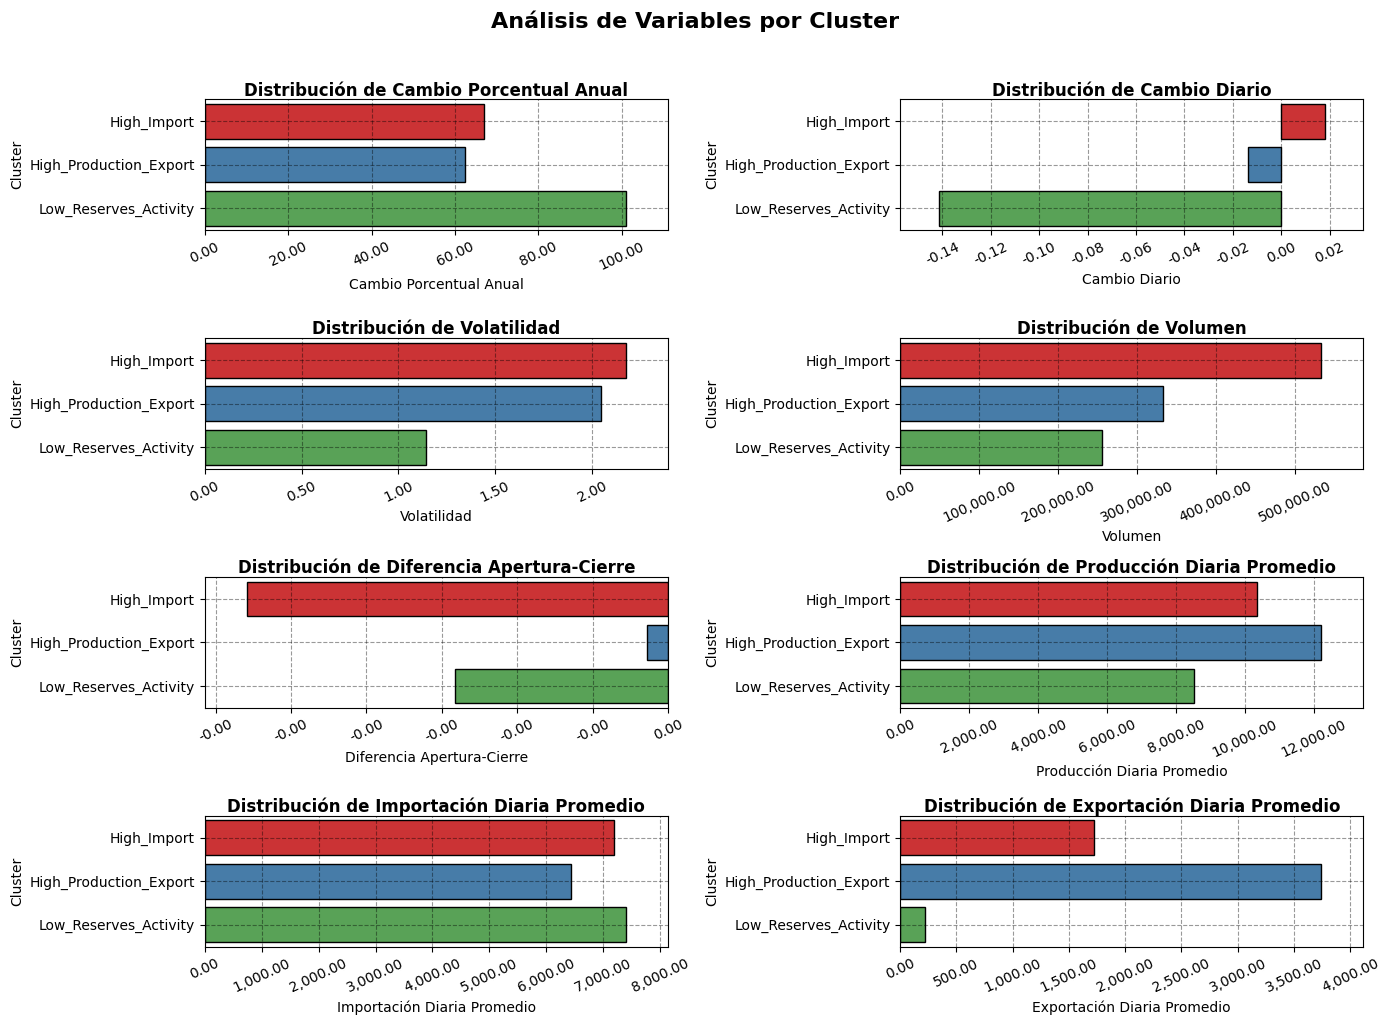

In [23]:
# Crear figura con subplots
fig, axes = plt.subplots(4, 2, figsize=(14, 10))
axes = axes.flatten()

# Definir nombres más legibles para las variables
variable_names = {
    "anual_pct_diff": "Cambio Porcentual Anual",
    "Change": "Cambio Diario",
    "volatility": "Volatilidad",
    "Volume": "Volumen",
    "diferencia_apertura_cierre": "Diferencia Apertura-Cierre",
    "produccion_diaria_promedio": "Producción Diaria Promedio",
    "importacion_diaria_promedio": "Importación Diaria Promedio",
    "exportacion_diaria_promedio": "Exportación Diaria Promedio"
}

variables = list(variable_names.keys())
palette = sns.color_palette("Set1", n_colors=len(centroides_analisis['cluster'].unique()))

for i, var in enumerate(variables):
    ax = sns.barplot(
        x=var,
        y='cluster',
        data=centroides_analisis,
        hue='cluster',
        edgecolor='black',
        palette=palette,
        ax=axes[i]
    )
    
    # Obtener los valores actuales y establecer nuevos ticks
    current_values = ax.get_xticks()
    ax.set_xticks(current_values)
    ax.set_xticklabels([f'{x:,.2f}' for x in current_values], rotation=25)
    
    # Ajustar títulos y etiquetas
    axes[i].set_title(f'Distribución de {variable_names[var]}', pad=2, fontsize=12, fontweight='bold')
    axes[i].set_xlabel(variable_names[var], fontsize=10)
    axes[i].set_ylabel('Cluster', fontsize=10)
    
    # Mejorar la cuadrícula
    axes[i].grid(axis='both', linestyle='--', color="black", alpha=0.4)
    
    # Ajustar los márgenes
    axes[i].margins(x=0.1)

plt.suptitle('Análisis de Variables por Cluster', fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

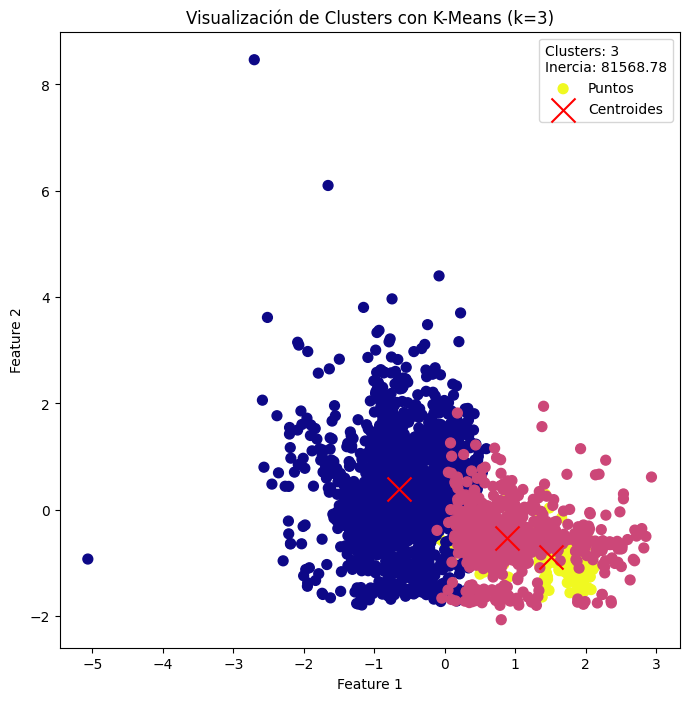

In [24]:
# Configuración del gráfico
plt.figure(figsize=(8, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='plasma', s=50, label="Puntos")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=300, c='red', marker='x', label="Centroides")

# Título y etiquetas
plt.title(f'Visualización de Clusters con K-Means (k={kmeans.n_clusters})')
plt.xlabel('Feature 1')  # Etiqueta del eje X (ajustar según el dataset)
plt.ylabel('Feature 2')  # Etiqueta del eje Y (ajustar según el dataset)

# Añade la información a la leyenda
plt.legend(title=f'Clusters: {kmeans.n_clusters}\nInercia: {inertia:.2f}', fontsize=10, title_fontsize=10)

plt.show()


### Validación de los clusters


=== Análisis de Silueta ===
Coeficiente de silueta promedio: 0.293


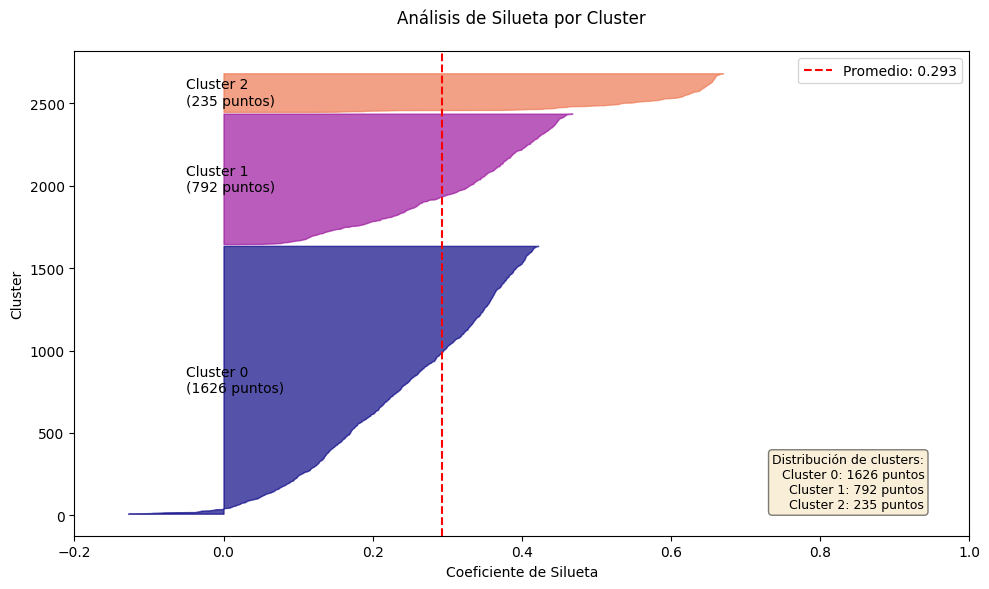

In [25]:

def analizar_silueta_basico(X_scaled, clusters, n_clusters=3):
    """
    Análisis básico de silueta usando los datos escalados
    """
    # Calcular el coeficiente de silueta promedio
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print("\n=== Análisis de Silueta ===")
    print(f"Coeficiente de silueta promedio: {silhouette_avg:.3f}")
    
    # Calcular siluetas por punto
    sample_silhouette_values = silhouette_samples(X_scaled, clusters)
    
    # Visualización de siluetas
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    for i in range(n_clusters):
        # Obtener los valores de silueta para el cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.plasma(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Añadir etiqueta del cluster con su tamaño
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, 
                f'Cluster {i}\n({size_cluster_i} puntos)', 
                verticalalignment='center')
        
        y_lower = y_upper + 10
    
    # Añadir línea de promedio y mejorar la visualización
    plt.axvline(x=silhouette_avg, color="red", linestyle="--", 
                label=f'Promedio: {silhouette_avg:.3f}')
    plt.title("Análisis de Silueta por Cluster", pad=20)
    plt.xlabel("Coeficiente de Silueta")
    plt.ylabel("Cluster")
    
    # Ajustar los límites del eje x para mejor visualización
    plt.xlim(-0.2, 1)
    plt.legend(loc='upper right')
    
    # Añadir información adicional
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join((
        'Distribución de clusters:',
        f'Cluster 0: {len(clusters[clusters == 0])} puntos',
        f'Cluster 1: {len(clusters[clusters == 1])} puntos',
        f'Cluster 2: {len(clusters[clusters == 2])} puntos'))
    plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, 
             fontsize=9, verticalalignment='bottom', 
             horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, sample_silhouette_values

# Ejecutar el análisis
sil_avg, sil_values = analizar_silueta_basico(X_scaled, clusters)

#### Medimos la distancia entre los puntos negativos y los centroides de todos los clústeres. Luego, se determina el clúster más cercano y se calcula la distancia a ese clúster. Finalmente, se añaden estas columnas al DataFrame de datos negativos

In [26]:
coefieciente_silueta = silhouette_samples(X_scaled, clusters)
puntos_negativos = X_scaled[coefieciente_silueta < 0]
cluster_negativo = clusters[coefieciente_silueta < 0]

# Crear un DataFrame para una inspección más sencilla
datos_negativos = pd.DataFrame(puntos_negativos)
datos_negativos['Cluster_Asignado'] = cluster_negativo


# Calcular distancias entre puntos negativos y todos los centroides
distancias_negativos = pairwise_distances(puntos_negativos, centroides)
# Calcular las distancias a los clústeres asignados
distancia_asignada = distancias_negativos[np.arange(len(cluster_negativo)), cluster_negativo]

# Determinar el índice del clúster más cercano
clusters_mas_cercanos = np.argmin(distancias_negativos, axis=1)

# Calcular las distancias al clúster más cercano
distancia_mas_cercano = distancias_negativos[np.arange(len(cluster_negativo)), clusters_mas_cercanos]

# Añadir estas columnas al DataFrame de datos negativos
datos_negativos['Distancia_Asignada'] = distancia_asignada
datos_negativos['Cluster_Mas_Cercano'] = clusters_mas_cercanos
datos_negativos['Distancia_Mas_Cercano'] = distancia_mas_cercano

####  Verificar si hay cambio de clúster

In [27]:
# Verificar si hay cambio de clúster
datos_negativos['Cambia_Cluster'] = datos_negativos['Cluster_Asignado'] != datos_negativos['Cluster_Mas_Cercano']
# Mostrar los primeros registros
# Verificar los puntos que realmente cambiaron de clúster
cambia_cluster = datos_negativos[datos_negativos["Cambia_Cluster"] == True]

# Calcular el porcentaje de cambios
porcentaje_cambios = (len(cambia_cluster) / len(datos_negativos)) * 100
# Ver los primeros puntos que cambiaron
cambia_cluster[['Cluster_Asignado', 'Cluster_Mas_Cercano', 'Distancia_Asignada', 'Distancia_Mas_Cercano']]

# Mostrar el número total de puntos que cambiaron de clúster
print(f"Total de puntos que cambiaron de clúster: {len(cambia_cluster)}")

# Mostrar el porcentaje de puntos que cambiaron de clúster
print(f"Porcentaje de puntos que cambiaron: {porcentaje_cambios:.2f}%")

# Si no hay cambios, mostrar un mensaje
if cambia_cluster.empty:
    print("No hay puntos que hayan cambiado de clúster.")
else:
    print(f"El número de puntos asignados a un clúster diferente al que le corresponde es: {len(cambia_cluster)}")

cambia_cluster[['Cluster_Asignado', 'Cluster_Mas_Cercano', 'Distancia_Asignada', 'Distancia_Mas_Cercano']].head()

Total de puntos que cambiaron de clúster: 32
Porcentaje de puntos que cambiaron: 100.00%
El número de puntos asignados a un clúster diferente al que le corresponde es: 32


,Cluster_Asignado,Cluster_Mas_Cercano,Distancia_Asignada,Distancia_Mas_Cercano
0,0,2,705890.8823,427925.7497
1,0,2,705890.5561,427925.4914
2,0,2,705891.1479,427925.9651
3,0,2,705892.0021,427926.6415
4,0,2,705891.0242,427925.8546


### Utilziamos PCA para reducir dimensiosión y poder entender mejor los que está pasando con los puntos negativos

In [28]:
# Aplicar PCA a los datos normalizados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transformar los puntos con silueta negativa y centroides
puntos_negativos_pca = pca.transform(puntos_negativos)
centroides_pca = pca.transform(kmeans.cluster_centers_)

### Visualización de los coefieficientes de silueta negativos respecto a su centroide asignado y los otros centroides aplicando PCA

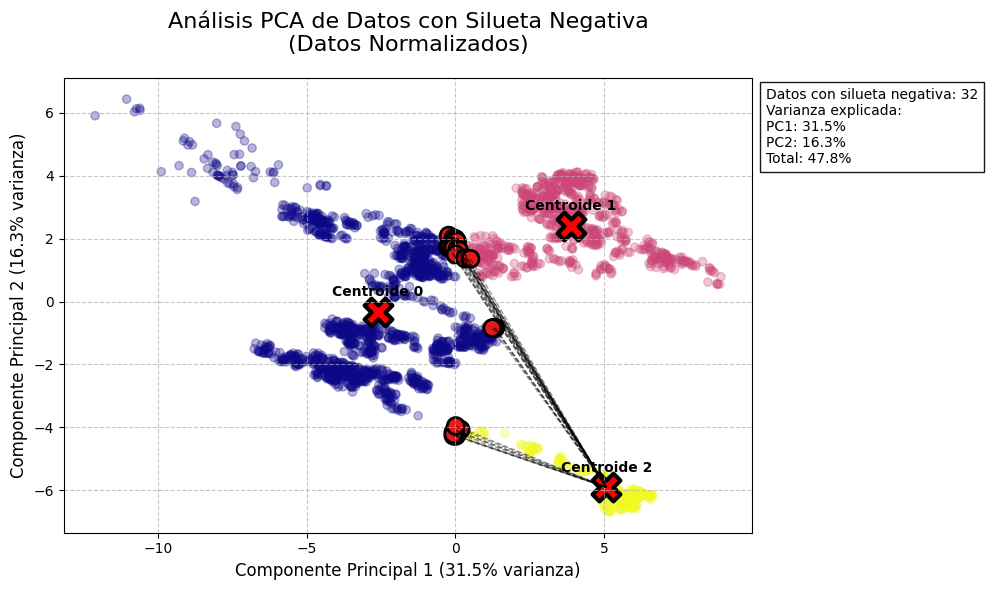


Distribución de datos con silueta negativa por cluster:
Cluster 0: 32 datos (100.0%)
Cluster 1: 0 datos (0.0%)
Cluster 2: 0 datos (0.0%)


In [29]:

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar todos los datos normalizados
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
           c=clusters,
           cmap='plasma',
           alpha=0.3)

# Graficar los datos con silueta negativa
plt.scatter(puntos_negativos_pca[:, 0], 
           puntos_negativos_pca[:, 1], 
           c=cluster_negativo,
           cmap='Set1',
           s=150,
           marker='o',
           edgecolor='black',
           linewidth=2)

# Graficar los centroides con etiquetas
for i, centroide in enumerate(centroides_pca):
    plt.scatter(centroide[0], centroide[1], 
               color='red',
               marker='X', 
               s=400,
               linewidth=3,
               edgecolor='black')
    # Añadir etiqueta del centroide encima de la X
    plt.text(centroide[0], centroide[1] + 0.4, 
            f'Centroide {i}',
            fontweight='bold',
            ha='center',
            va='bottom')

# Dibujar líneas a los centroides más cercanos
for i, punto in enumerate(puntos_negativos_pca):
    centroide_cercano = centroides_pca[clusters_mas_cercanos[i]]
    plt.plot([punto[0], centroide_cercano[0]], 
             [punto[1], centroide_cercano[1]], 
             '--', 
             color="black",
             alpha=0.4,
             linewidth=1)

# Añadir información
plt.text(1.02, 0.98, 
         f'Datos con silueta negativa: {len(puntos_negativos)}\n' + 
         f'Varianza explicada:\n' +
         f'PC1: {pca.explained_variance_ratio_[0]:.1%}\n' +
         f'PC2: {pca.explained_variance_ratio_[1]:.1%}\n' +
         f'Total: {sum(pca.explained_variance_ratio_):.1%}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'),
         verticalalignment='top')

plt.title('Análisis PCA de Datos con Silueta Negativa\n(Datos Normalizados)', 
         fontsize=16, pad=20)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)', 
          fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)', 
          fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Distribución de datos con silueta negativa
print("\nDistribución de datos con silueta negativa por cluster:")
for i in range(kmeans.n_clusters):
    n_datos = sum(cluster_negativo == i)
    porcentaje = (n_datos / len(cluster_negativo)) * 100
    print(f"Cluster {i}: {n_datos} datos ({porcentaje:.1f}%)")

### Análisis de  la importación,exportación y producción diaria promedio para cada cluster.

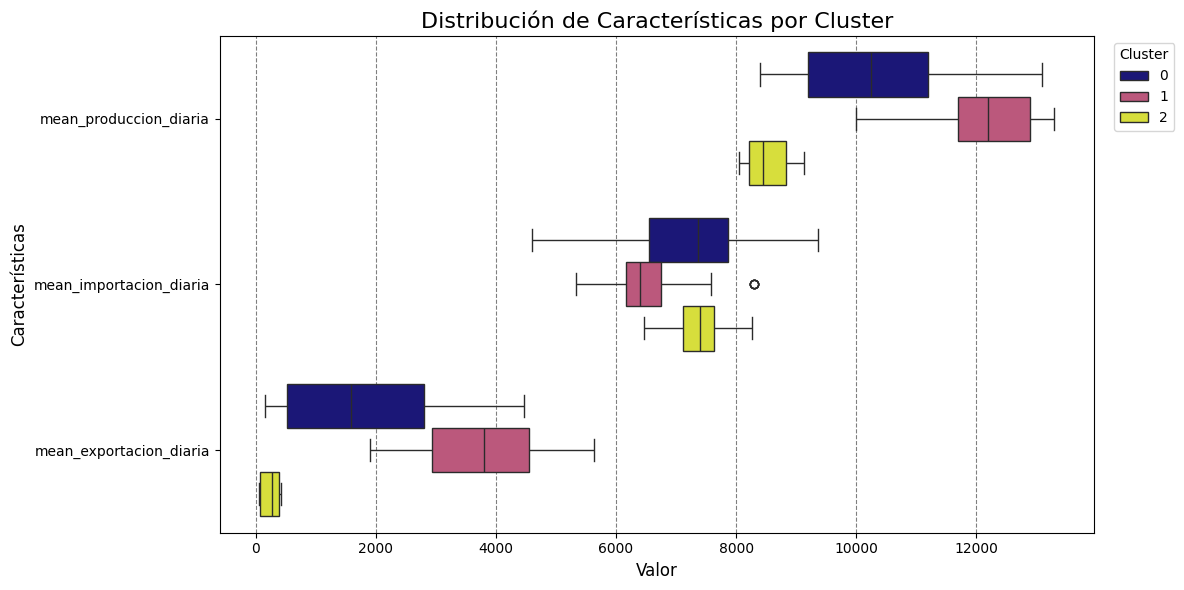

produccion_diaria_promedio                                             \
                             count       mean       std        min        25%   
cluster                                                                         
0                        1626.0000 10364.7380 1350.5406  8406.0000  9192.0000   
1                         792.0000 12220.7071  702.1553 10000.0000 11700.0000   
2                         235.0000  8516.3617  325.4040  8044.0000  8222.0000   

                                         importacion_diaria_promedio  \
               50%        75%        max                       count   
cluster                                                                
0       10251.0000 11200.0000 13100.0000                   1626.0000   
1       12200.0000 12900.0000 13300.0000                    792.0000   
2        8453.0000  8838.0000  9137.0000                    235.0000   

                   ... exportacion_diaria_promedio             cluster         \
             mean  ...                         75%       max     count   mean   
cluster            ...                                                          
0       7181.4815  ...                   2803.0000 4462.0000 1626.0000 0.0000   
1       6436.5101  ...                   4544.2500 5629.0000  792.0000 1.0000   
2       7394.9872  ...                    385.0000  420.0000  235.0000 2.0000   

                                                   
           std    min    25%    50%    75%    max  
cluster                                            
0       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
1       0.0000 1.0000 1.0000 1.0000 1.0000 1.0000  
2       0.0000 2.0000 2.0000 2.0000 2.0000 2.0000  

[3 rows x 32 columns]

In [30]:
# Preparar los datos para el boxplot
data_for_box = df[["produccion_diaria_promedio", 
                   "importacion_diaria_promedio",
                   "exportacion_diaria_promedio",
                   "cluster"]]

# Crear los datos en formato largo
melted_data = pd.melt(data_for_box, 
                    id_vars=['cluster'], 
                    value_vars=['produccion_diaria_promedio',
                              'importacion_diaria_promedio',
                              'exportacion_diaria_promedio'])

# Crear figura
plt.figure(figsize=(12, 6))

# Crear boxplot horizontal
sns.boxplot(x="value", 
            y="variable",
            hue="cluster",
            data=melted_data,
            orient='h',
            palette="plasma")

# Personalizar el gráfico
plt.title('Distribución de Características por Cluster', fontsize=16)
plt.xlabel('Valor', fontsize=12)
plt.ylabel('Características', fontsize=12,)

# Cambiar las etiquetas del eje y
plt.gca().set_yticklabels(['mean_produccion_diaria', 'mean_importacion_diaria', 'mean_exportacion_diaria',])

# Ajustar la leyenda
plt.legend(title='Cluster', bbox_to_anchor=(1.1, 1))

# Añadir grid
plt.grid(axis='x', linestyle='--', alpha=0.5, color="black")

plt.tight_layout()
plt.show()

df.groupby("cluster")[["produccion_diaria_promedio", 
                   "importacion_diaria_promedio",
                   "exportacion_diaria_promedio",
                   "cluster"]].describe()


In [31]:
# Datos filtrados
datos_filtrados = df[["produccion_diaria_promedio", 
                      "importacion_diaria_promedio", 
                      "exportacion_diaria_promedio"]]

# Centroides filtrados
centroides_filtrados = centroides[["produccion_diaria_promedio", 
                                   "importacion_diaria_promedio", 
                                   "exportacion_diaria_promedio"]]

# Crear el scatter plot para los datos, coloreando según el cluster
scatter_datos = go.Scatter3d(
    x=datos_filtrados["produccion_diaria_promedio"],
    y=datos_filtrados["importacion_diaria_promedio"],
    z=datos_filtrados["exportacion_diaria_promedio"],
    mode='markers',
    marker=dict(
        size=5,
        color=clusters,  # Colorear por clúster (labels de KMeans)
        colorscale='Plasma',  # Escala de colores
        opacity=0.7
    ),
    name="Datos"
)

# Crear el scatter plot para los centroides
scatter_centroides = go.Scatter3d(
    x=centroides_filtrados["produccion_diaria_promedio"],
    y=centroides_filtrados["importacion_diaria_promedio"],
    z=centroides_filtrados["exportacion_diaria_promedio"],
    mode='markers+text',
    marker=dict(
        size=10,
        color='red',  # Centroides en rojo
        symbol='x'  # Símbolo en forma de cruz
    ),
    text=[f'Centroide {i+1}' for i in range(len(centroides_filtrados))],  # Etiquetas de los centroides
    textposition="top center",
    name="Centroides"
)

# Configurar el layout con un tamaño cuadrado
layout = go.Layout(
    title="Visualización Interactiva de Datos Coloreados por Clúster",
    scene=dict(
        xaxis_title="Producción Diaria Promedio",
        yaxis_title="Importación Diaria Promedio",
        zaxis_title="Exportación Diaria Promedio",
        aspectmode="cube"  # Proporciones iguales en los ejes
    ),
    width=750,  # Ancho del gráfico (ajustar según prefieras)
    height=500,  # Alto del gráfico (igual al ancho para hacerlo cuadrado)
    legend=dict(
        x=0.8, y=0.9, title="Leyenda"
    )
)

# Crear la figura combinando los datos y los centroides
fig = go.Figure(data=[scatter_datos, scatter_centroides], layout=layout)

# Mostrar el gráfico
fig.show()

---

### Realizamos PCA + Kmeans

In [32]:
# Aplicamos PCA con 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Aplicamos K-means sobre los datos transformados por PCA
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [33]:
# Crear DataFrame con las componentes principales
df_pca = pd.DataFrame(
    data=X_pca,
    columns=['PC1', 'PC2', 'PC3'],
    index=df.index
)

# Añadir la columna de clusters
df_pca['Cluster'] = clusters

# Mostrar las primeras filas del nuevo DataFrame
print("Primeras filas del DataFrame PCA:")
print(df_pca.head())

# Mostrar información básica del DataFrame
print("\nInformación del DataFrame:")
df_pca.info()

Primeras filas del DataFrame PCA:
     PC1     PC2     PC3  Cluster
5 5.0048 -6.5877 -0.1161        2
6 5.0188 -6.3872 -0.0849        2
7 4.9454 -6.3644 -0.2517        2
8 4.9176 -6.3544 -0.0708        2
9 4.9870 -6.3423 -0.0540        2

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 5 to 2657
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      2653 non-null   float64
 1   PC2      2653 non-null   float64
 2   PC3      2653 non-null   float64
 3   Cluster  2653 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 72.7 KB


#### Correción de valores

In [34]:
# Corregir valor atípico en el cluster 0
df_pca[df_pca["Cluster"] == 0].sort_values(by="PC3", ascending=False).head()
df_pca.loc[1106] = df_pca["PC1"].median()

#### Visualización del cluster con PCA

In [35]:
# Guardamos los resultados en el dataframe original
df['Cluster'] = clusters

# Añadimos las componentes principales como nuevas columnas
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]
df['PC3'] = X_pca[:, 2]

# Crear el scatter plot para los datos PCA
scatter_datos = go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=clusters,
        colorscale='plasma',  # Usando el mismo colormap que matplotlib
        opacity=0.7,
        showscale=True,  # Mostrar la barra de color
        colorbar=dict(
            title='Cluster'
        )
    ),
    name="Datos"
)

# Crear el scatter plot para los centroides
centroides = kmeans.cluster_centers_
scatter_centroides = go.Scatter3d(
    x=centroides[:, 0],
    y=centroides[:, 1],
    z=centroides[:, 2],
    mode='markers+text',
    marker=dict(
        size=12,
        color='red',
        symbol='x',
        line=dict(width=3)
    ),
    text=[f'Centroide {i}' for i in range(len(centroides))],
    textposition="top center",
    name="Centroides"
)

# Configurar el layout
layout = go.Layout(
    title=dict(
        text='Clusters K-means en espacio PCA 3D',
        y=0.95
    ),
    scene=dict(
        xaxis_title="Primera Componente",
        yaxis_title="Segunda Componente",
        zaxis_title="Tercera Componente",
        aspectmode='cube'
    ),
    width=750,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.8
    )
)

# Crear la figura
fig = go.Figure(data=[scatter_datos, scatter_centroides], layout=layout)

# Añadir información sobre la varianza explicada y la inercia
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

fig.add_annotation(
    x=1,
    y=0.5,
    xref="paper",
    yref="paper",
    text=f"<b>Varianza explicada</b><br>" +
         f"PC1: {var_explicada[0]:.2%}<br>" +
         f"PC2: {var_explicada[1]:.2%}<br>" +
         f"PC3: {var_explicada[2]:.2%}<br>" +
         f"Total: {var_acumulada[2]:.2%}<br>" +
         f"Inercia: {kmeans.inertia_:.2f}",
    showarrow=False,
    bordercolor="black",
    borderwidth=1,
    bgcolor="white",
    font=dict(size=12)
)
fig.show()



# Imprimir información adicional
print("\nTamaño de cada cluster:")
n_cluster = pd.Series(clusters).value_counts().sort_index()
print(n_cluster)

# Calcular el porcentaje de cada clúster respecto al total
porcentaje_cluster = (n_cluster / len(clusters)) * 100

# Imprimir el porcentaje
print("\nRepresentación de cada Cluster en %:")
for cluster, porcentaje in porcentaje_cluster.items():
    print(f"Cluster {cluster}: {porcentaje:.2f}%")


Tamaño de cada cluster:
0    1628
1     793
2     232
Name: count, dtype: int64

Representación de cada Cluster en %:
Cluster 0: 61.36%
Cluster 1: 29.89%
Cluster 2: 8.74%


#### Variables usadas en el PCA

In [36]:
# Obtener las variables que realmente se usaron en el PCA (excluyendo 'cluster' y las nuevas columnas)
variables_pca = [col for col in df.columns if col not in ['cluster', 'Cluster', 'PC1', 'PC2', 'PC3']]

# Crear DataFrame de componentes
componentes = pd.DataFrame(
    data=pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=variables_pca
)

# Mostrar la varianza explicada
print("Varianza explicada por cada componente:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")
print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.4f} "
      f"({sum(pca.explained_variance_ratio_)*100:.2f}%)")

# Encontrar las variables más importantes para cada componente
print("\nVariables más importantes para cada componente:")
for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\nTop 10 variables más influyentes en {pc}:")
    contributions = abs(componentes[pc]).sort_values(ascending=False).head(10)
    for var, value in contributions.items():
        print(f"{var}: {componentes.loc[var, pc]:.3f}")

Varianza explicada por cada componente:
PC1: 0.3153 (31.53%)
PC2: 0.1632 (16.32%)
PC3: 0.0610 (6.10%)
Varianza total explicada: 0.5395 (53.95%)

Variables más importantes para cada componente:

Top 10 variables más influyentes en PC1:
day_max_anterior: 0.255
weekly_max: 0.255
weekly_max_anterior: 0.255
day_min_anterior: 0.255
Close: 0.254
weekly_min_anterior: 0.253
weekly_min: 0.253
monthly_max: 0.252
monthly_min: 0.246
monthly_max_anterior: 0.246

Top 10 variables más influyentes en PC2:
year: 0.330
exportacion_cambio_acumulativo: 0.324
produccion_cambio_acumulativo: 0.324
exportacion_diaria_promedio: 0.318
produccion_diaria_promedio: 0.317
importacion_cambio_acumulativo: 0.301
Close_sp500: 0.291
anual_pct_diff: -0.251
Close_eurusd: -0.226
inventario_cambio_acumulativo: 0.221

Top 10 variables más influyentes en PC3:
corr_oil_xle: 0.575
corr_oil_sp500: 0.573
corr_oil_eurusd: 0.568
Change_diff: 0.056
racha_change: 0.049
weekly_pct_diff: -0.044
Change: 0.041
Volume: -0.038
volatility: -

#### Contribución de cada variable a cada componente principal



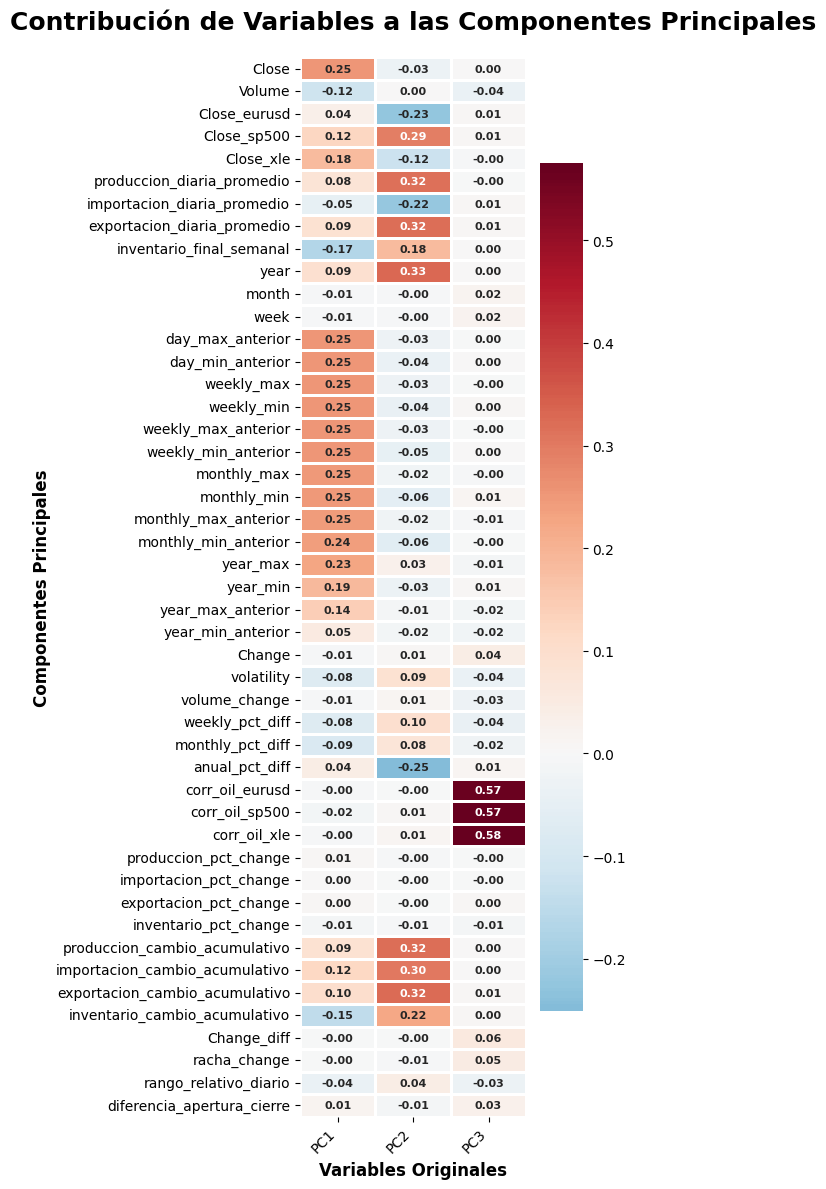

In [37]:
# Crear la figura con el tamaño especificado
plt.figure(figsize=(6 , 12))

# Crear el heatmap con mejoras visuales
ax = sns.heatmap(componentes, 
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            xticklabels=True,
            yticklabels=True,
            annot_kws={
                'size': 8,
                'weight': 'bold'
            },
            linewidths=1,
            linecolor='white'
)

# Personalizar el título
plt.title('Contribución de Variables a las Componentes Principales', 
          pad=20, size=18, weight='bold')

# Mejorar las etiquetas de los ejes
plt.xlabel('Variables Originales', size=12, weight='bold')
plt.ylabel('Componentes Principales', size=12, weight='bold')

# Rotar y ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')  # Rotación de 45 grados, alineación a la derecha
plt.yticks(rotation=0)

# Ajustar la posición de las etiquetas para evitar el recorte
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Ajustar los márgenes y el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Aplicación de PCA con más componentes para analizar la distribución de la varianza

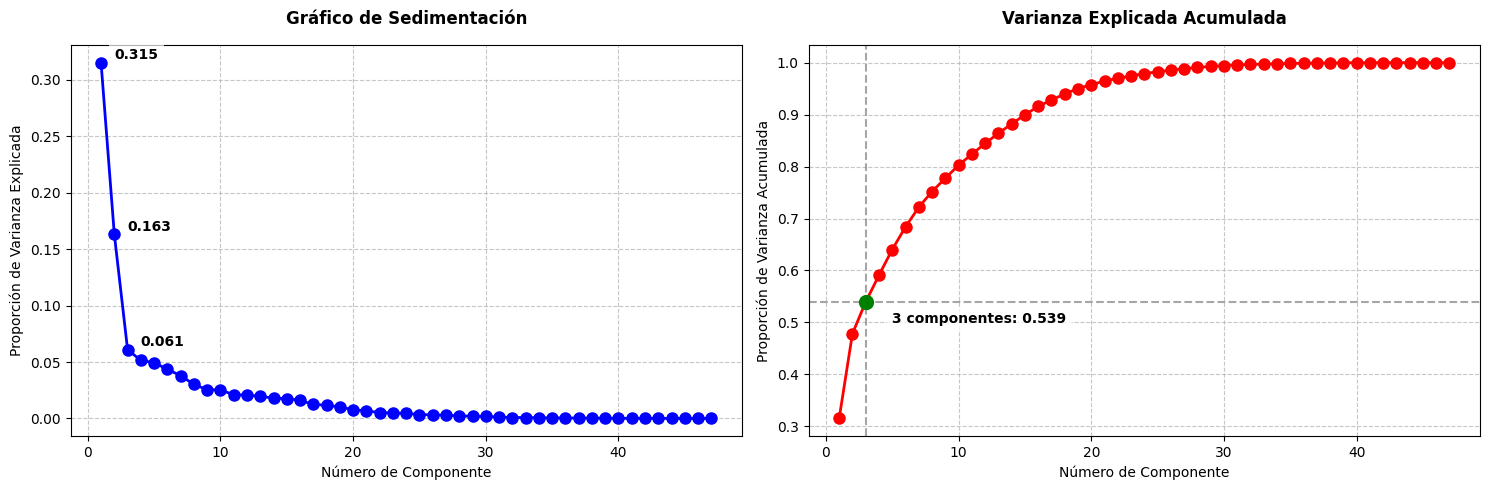


Contribuciones principales por componente:

Componente 1 (31.5% de la varianza):
  day_max_anterior: 0.255
  weekly_max: 0.255
  weekly_max_anterior: 0.255
  day_min_anterior: 0.255
  Close: 0.254

Componente 2 (16.3% de la varianza):
  year: 0.330
  exportacion_cambio_acumulativo: 0.324
  produccion_cambio_acumulativo: 0.324
  exportacion_diaria_promedio: 0.318
  produccion_diaria_promedio: 0.317

Componente 3 (6.1% de la varianza):
  corr_oil_xle: 0.575
  corr_oil_sp500: 0.573
  corr_oil_eurusd: 0.568
  Change_diff: 0.056
  racha_change: 0.049


In [38]:
# Aplicar PCA con más componentes para ver la distribución de la varianza
pca_analysis = PCA()  # Sin especificar n_components usará el máximo posible
X_pca_full = pca_analysis.fit_transform(X_scaled)

# Obtener la varianza explicada
prop_var = pca_analysis.explained_variance_ratio_

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. Gráfico de sedimentación (Scree plot)
pc_numbers = np.arange(len(prop_var)) + 1
ax1.plot(pc_numbers, prop_var, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Gráfico de Sedimentación', size=12, pad=15, weight='bold')
ax1.set_xlabel('Número de Componente', size=10)
ax1.set_ylabel('Proporción de Varianza Explicada', size=10)
ax1.grid(True, linestyle='--', alpha=0.7)

# Anotar los primeros 3 componentes con posición ajustada
for i in range(3):
    ax1.text(i + 2,  # Movido a la derecha (1.2 en lugar de 1)
             prop_var[i] + 0.013,  # Bajado un poco (-0.02)
             f'{prop_var[i]:.3f}', 
             ha='left',  # Alineación a la izquierda
             va='top',   # Alineación vertical arriba
             weight='bold',
             bbox=dict(facecolor='white', 
                      edgecolor='none', 
                      alpha=0.7))

# 2. Varianza acumulada
var_acum = np.cumsum(prop_var)
ax2.plot(pc_numbers, var_acum, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Varianza Explicada Acumulada', size=12, pad=15, weight='bold')
ax2.set_xlabel('Número de Componente', size=10)
ax2.set_ylabel('Proporción de Varianza Acumulada', size=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# Anotar el punto donde usamos 3 componentes con posición ajustada
ax2.axvline(x=3, color='gray', linestyle='--', alpha=0.7)
ax2.axhline(y=var_acum[2], color='gray', linestyle='--', alpha=0.7)
ax2.plot(3, var_acum[2], 'go', markersize=10)
ax2.text(5.0,  # Movido más a la derecha
         var_acum[2] - 0.02,  # Bajado un poco
         f'3 componentes: {var_acum[2]:.3f}', 
         va='top',
         ha='left',
         weight='bold',
         bbox=dict(facecolor='white', 
                  edgecolor='none', 
                  alpha=0.7))

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Mostrar las contribuciones de las variables a los primeros 3 componentes
print("\nContribuciones principales por componente:")
for i in range(3):
    print(f"\nComponente {i+1} ({prop_var[i]*100:.1f}% de la varianza):")
    component_loading = pca_analysis.components_[i]
    # Obtener las 5 variables con mayor contribución absoluta
    top_features_idx = np.argsort(np.abs(component_loading))[-5:]
    for idx in reversed(top_features_idx):
        variable = variables_pca[idx]
        contribucion = component_loading[idx]
        print(f"  {variable}: {contribucion:.3f}")

---

### Analisis de Noticias y su correlación con la producción, importación, exportación

In [39]:
# Recueprar las variables categóricas
df_categorico = df_cl.select_dtypes(include=['object', 'category'])
# Realizar el left join
df = df.merge(df_categorico, left_index=True, right_index=True, how='left')

In [40]:
df.drop(columns=['cluster'], inplace=True)
df.rename(columns={"cluster": "Cluster"}, inplace=True)

In [41]:
def cluster_to_label(row):
    """
    Convertir el número de cluster a una etiqueta
    """
    if row["Cluster"] == 0:
        return "Cluster_High_Import"
    elif row["Cluster"] == 1:
        return "Cluster_High_Production_Export"
    else:
        return "Cluster_Low_Reserves_Activity"
    
# Aplicar la función y crear una nueva columna
df["Cluster"] = df.apply(cluster_to_label, axis=1)

#### Key Events anual por cada  cluster

In [42]:
df.groupby("Cluster")[["annual_key_events"]].value_counts(normalize=True) * 100

Cluster                         annual_key_events                                                                         
Cluster_High_Import             COVID-19 desploma demanda y precios. OPEP+ acuerda recorte histórico.                         15.6634
                                Caída prolongada de precios. Reducción de inversiones en exploración y producción.            15.6634
                                Ataque a Aramco provoca alza de precios. Aumenta la presión por la transición energética.     15.4177
                                EE.UU. se convierte en mayor productor. Tensiones comerciales con China afectan mercado.      15.4177
                                Extensión de recortes OPEP+. Aumento de producción de esquisto en EE.UU.                      15.4177
                                Acuerdo OPEP para reducir producción; precios suben a $50. Recuperación lenta del mercado.    15.3563
                                Recuperación de precios. Mayor enfoque en

#### Noticias donde aparece **"Record"** por cada  cluster

In [43]:
# Filtrar por cluster y las noticias que contengan la palabra "Record"
noticias_record = df[df["Noticia_EIA"].str.contains("Record", case=False, na=False)]
n_noticias_record = noticias_record.count().iloc[0]
print("Numero de veces que aparece la palabra (Record):\n", n_noticias_record)

print("\nNoticias que contienen la palabra 'Record' por cluster:\n")

# Mostrar la distribución de noticias por cluster
noticias_record.groupby("Cluster")["Noticia_EIA"].value_counts(normalize=True) * 100

Numero de veces que aparece la palabra (Record):
 44

Noticias que contienen la palabra 'Record' por cluster:



Cluster                         Noticia_EIA                                                                               
Cluster_High_Import             Canada provides record-high share and amount of U.S. crude oil imports in 2015                4.5455
                                Crude oil and petroleum product exports reach record levels in the first half of 2017         4.5455
                                Crude oil storage at Cushing, but not storage capacity utilization rate, at record level      4.5455
                                EIA expects total U.S. fossil fuel production to reach record levels in 2018 and 2019         4.5455
                                Oil production in federal Gulf of Mexico projected to reach record high in 2017               4.5455
                                The number of active U.S. crude oil and natural gas rigs is at the lowest point on record     4.5455
                                U.S. Federal Gulf of Mexico crude oil productio

,Change,volatility,Volume
Cluster,,,
Cluster_High_Import,1.6918,2.9582,540284.4091
Cluster_High_Production_Export,1.1280,1.8445,308951.6500
Cluster_Low_Reserves_Activity,-0.3250,0.6700,192873.0000


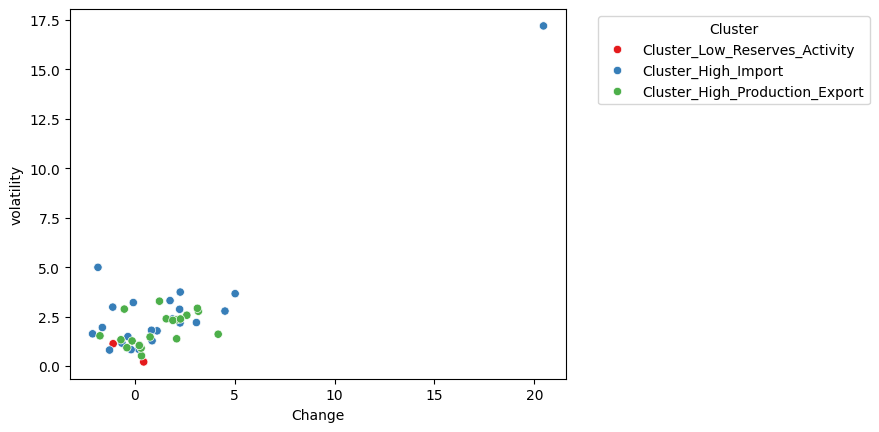

In [44]:
# Análisis de sentimientos
sns.scatterplot(data=noticias_record, x="Change", y="volatility", hue="Cluster", palette="Set1")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='best')
noticias_record.groupby("Cluster")[["Change","volatility","Volume"]].mean()

#### Noticias donde aparece **"import"** por cada  cluster

In [45]:
# Filtrar por Cluster y noticias que contengan la palabra "import"
noticias_import = df[df["Noticia_EIA"].str.contains("import", case=False, na=False)]
n_noticias_import = noticias_import.count().iloc[0]
print("Numero de veces que aparece la palabra (import):\n", n_noticias_import)

print("\nNoticias que contienen la palabra 'import' por cluster:\n")
noticias_import.groupby("Cluster")[["Noticia_EIA"]].value_counts(normalize=True) * 100

Numero de veces que aparece la palabra (import):
 52

Noticias que contienen la palabra 'import' por cluster:



Cluster                         Noticia_EIA                                                                               
Cluster_High_Import             China surpassed the United States as the world’s largest crude oil importer in 2017           4.8780
                                The Strait of Hormuz is the world's most important oil transit chokepoint                     4.8780
                                As total U.S. crude oil imports fall, Canada’s import supply share rises                      2.4390
                                As total U.S. crude oil imports have fallen, imports from Canada have increased               2.4390
                                Canada is the largest source of U.S. energy imports                                           2.4390
                                Canada provides record-high share and amount of U.S. crude oil imports in 2015                2.4390
                                China’s crude oil imports surpassed 10 million 

,Change,volatility,Volume
Cluster,,,
Cluster_High_Import,0.6771,2.6280,535665.6098
Cluster_High_Production_Export,-0.1800,2.2287,223727.7500
Cluster_Low_Reserves_Activity,1.1400,1.5100,272042.0000


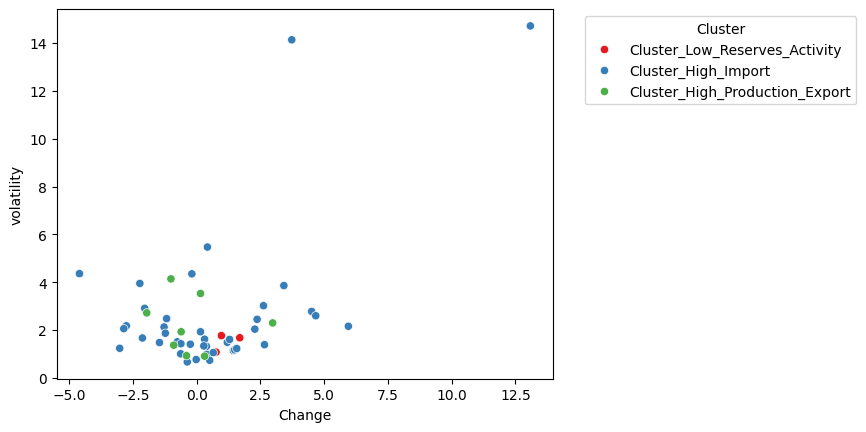

In [46]:
# Análisis de sentimientos
sns.scatterplot(data=noticias_import, x="Change", y="volatility", hue="Cluster", palette="Set1")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='best')
noticias_import.groupby("Cluster")[["Change","volatility","Volume"]].mean()

#### Noticias donde aparece **"export"** por cada  cluster

In [47]:
# Filtrar por Cluster y noticias que contengan la palabra "export"
noticias_export = df[df["Noticia_EIA"].str.contains("export", case=False, na=False)]
n_noticias_export = noticias_export.count().iloc[0]
print("Numero de veces que aparece la palabra (export):\n", n_noticias_export)

print("\nNoticias que contienen la palabra 'export' por cluster:\n")
noticias_export.groupby("Cluster")[["Noticia_EIA"]].value_counts(normalize=True) * 100

Numero de veces que aparece la palabra (export):
 54

Noticias que contienen la palabra 'export' por cluster:



Cluster                         Noticia_EIA                                                                               
Cluster_High_Import             EIA now publishes petroleum export data by U.S. region of origin and destination country      5.0000
                                China is a key destination for increasing U.S. energy exports                                 2.5000
                                Crude oil and petroleum product exports reach record levels in the first half of 2017         2.5000
                                Crude oil was the largest U.S. petroleum export in the first half of 2018                     2.5000
                                Currency depreciation against the dollar affects oil importers and exporters differently      2.5000
                                EIA forecasts the U.S. will import more petroleum than it exports in 2021 and 2022            2.5000
                                Effects of removing U.S. crude export restricti

,Change,volatility,Volume
Cluster,,,
Cluster_High_Import,0.2485,2.0312,543928.0500
Cluster_High_Production_Export,0.5117,2.6125,294315.5833
Cluster_Low_Reserves_Activity,-0.3000,0.8750,249487.5000


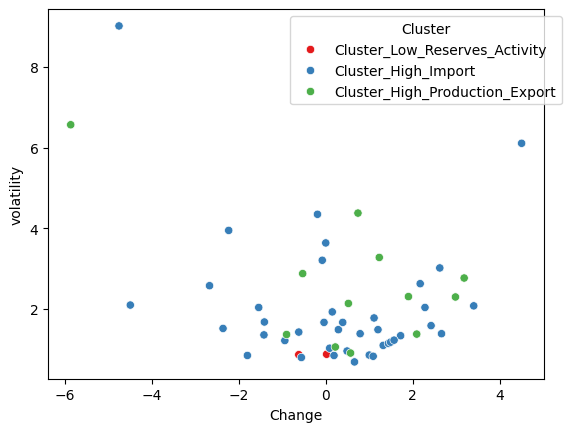

In [48]:
# Análisis de sentimientos
sns.scatterplot(data=noticias_export, x="Change", y="volatility", hue="Cluster", palette="Set1")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='best')
noticias_export.groupby("Cluster")[["Change","volatility","Volume"]].mean()

#### Gráficos de distribución densidad para volatilidad y volumen por perfil.

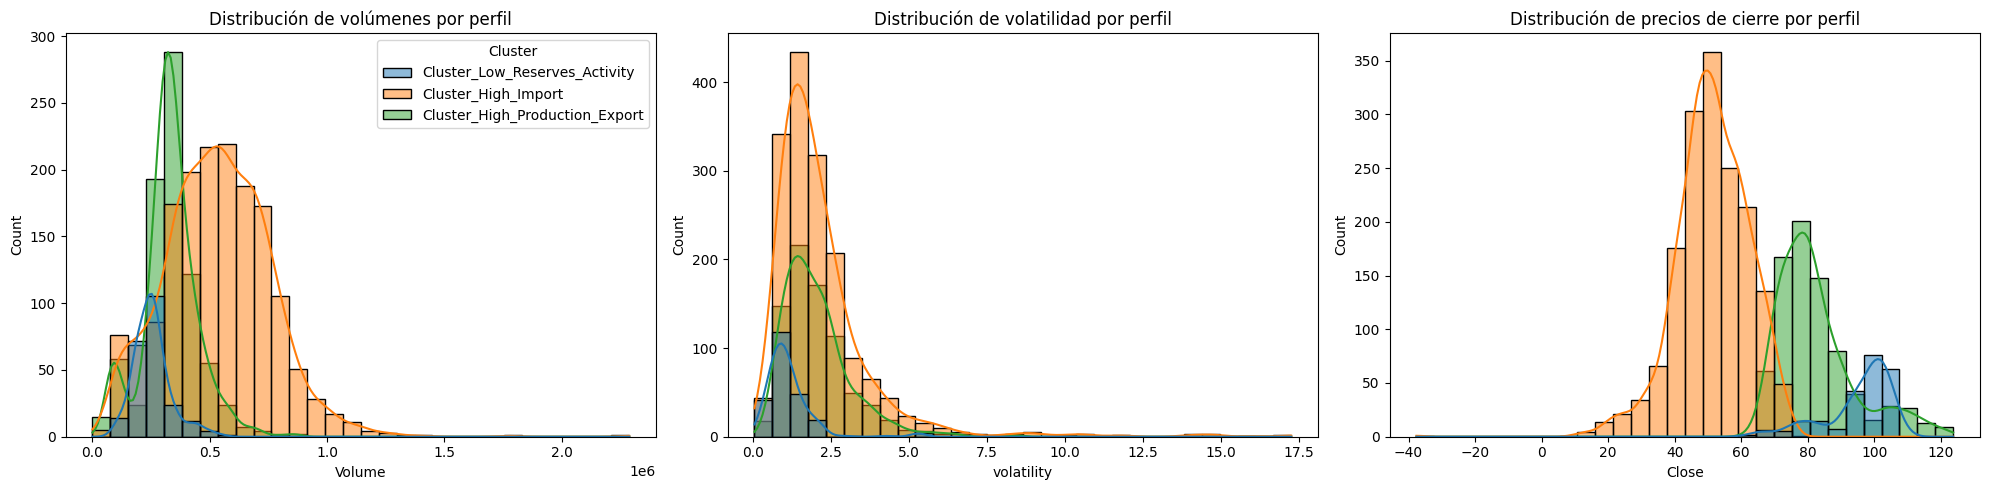

In [49]:
# Crear una figura con tres subplots horizontales
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Histograma para volumen 
sns.histplot(data=df, 
            x='Volume', 
            hue='Cluster', 
            kde=True, 
            bins=30,
            ax=ax1,
            legend=True)
ax1.set_title('Distribución de volúmenes por perfil')

# Histograma para volatilidad
sns.histplot(data=df, 
            x='volatility', 
            hue='Cluster', 
            kde=True, 
            bins=30,
            ax=ax2,
            legend=False)  # No mostrar leyenda en el segundo gráfico
ax2.set_title('Distribución de volatilidad por perfil')

# Histograma para precios de cierre
sns.histplot(data=df, 
            x='Close', 
            hue='Cluster', 
            kde=True, 
            bins=30,
            ax=ax3,
            legend=False)  # No mostrar leyenda en el tercer gráfico
ax3.set_title('Distribución de precios de cierre por perfil')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

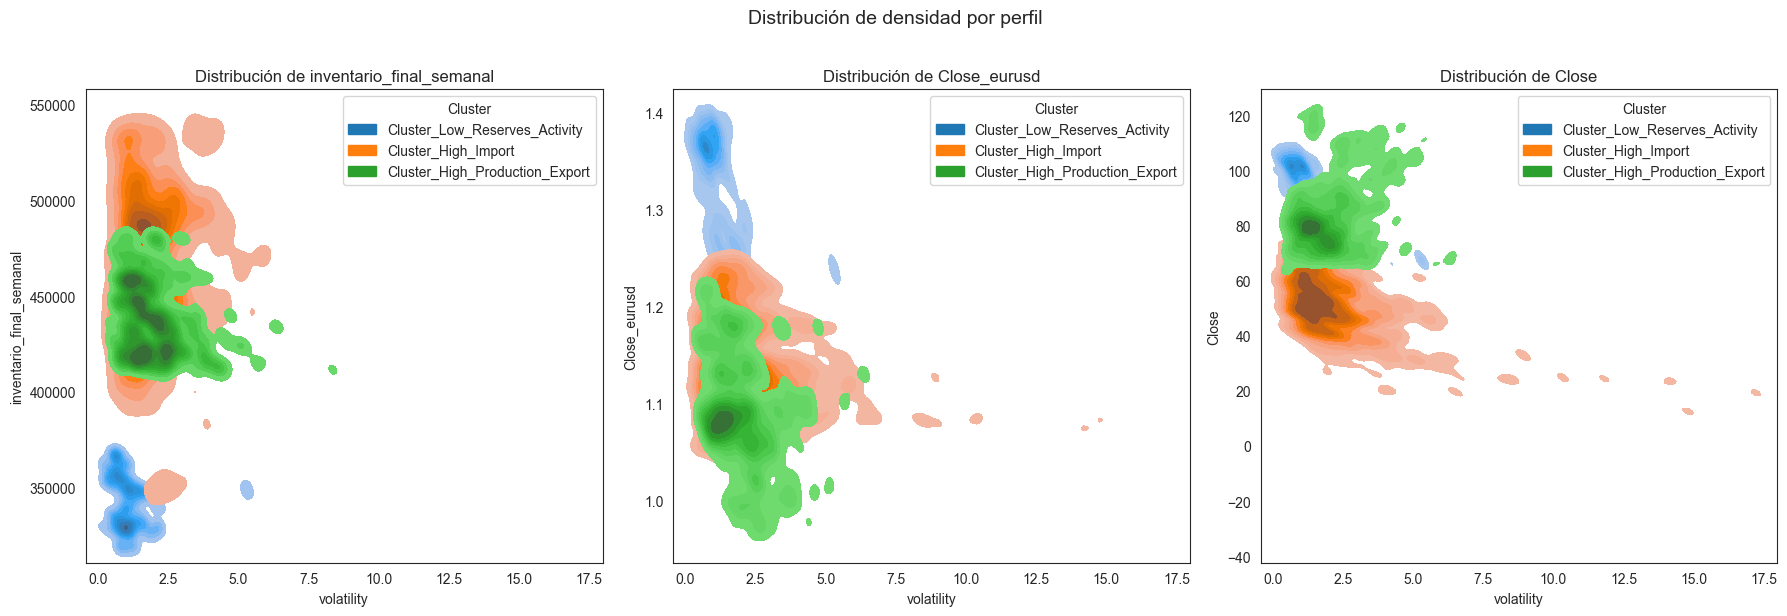

In [50]:
# Grafico de densidad por perfil
sns.set_style("white")

# Lista de variables específicas
variables = ['inventario_final_semanal', 'Close_eurusd', 'Close']

# Crear una figura con subplots horizontales
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas
fig.suptitle('Distribución de densidad por perfil', y=1.02, fontsize=14)

# Crear los KDE plots para las variables especificadas
for i, (col, ax) in enumerate(zip(variables, axes)):
    sns.kdeplot(data=df, 
                x='volatility', 
                y=col,
                hue='Cluster',
                cmap="Blues", 
                fill=True, 
                bw_adjust=0.5,
                ax=ax)
    ax.set_title(f'Distribución de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

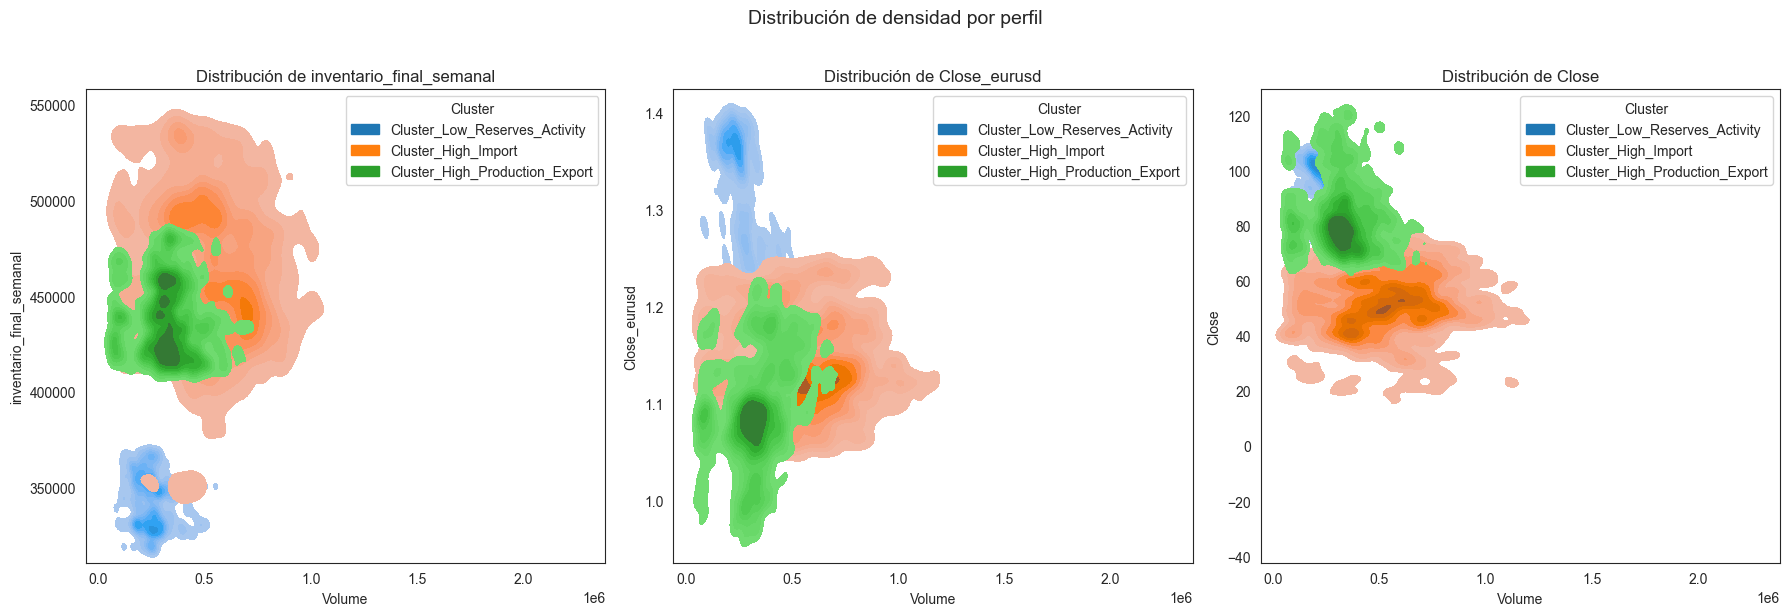

In [51]:
sns.set_style("white")

# Lista de variables específicas
variables = ['inventario_final_semanal', 'Close_eurusd', 'Close']

# Crear una figura con subplots horizontales
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas
fig.suptitle('Distribución de densidad por perfil', y=1.02, fontsize=14)

# Crear los KDE plots para las variables especificadas
for i, (col, ax) in enumerate(zip(variables, axes)):
    sns.kdeplot(data=df, 
                x='Volume', 
                y=col,
                hue='Cluster',
                cmap="Blues", 
                fill=True, 
                bw_adjust=0.5,
                ax=ax)
    ax.set_title(f'Distribución de {col}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()